In [484]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir_format="cpu"'
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from tools.common import disp_grid
from IPython.display import Image
from skimage.io import imsave

from keras.models import model_from_json
import os
import joblib
import numpy as np
from lightjob.cli import load_db
#from skimage.io import imread
from tools.common import find_generation_job, find_training_job, to_generation, compute_sample_objectness, resize_set
from IPython.display import Image, display
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import pandas as pd
import h5py
import cv2

from skimage.transform import resize

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from joblib.parallel import delayed, Parallel


def disp_pred(pred, h=20, w=100, y0=25):
    nb_classes = len(pred)
    img = np.zeros((nb_classes * h, w, 3))
    cv2.rectangle(img,(0,0),(img.shape[1],img.shape[0]),(0.3,0.3,0.3),3)
    pad = 0
    col = [[0, 0, 1]] * nb_classes
    for i in range(nb_classes):
        p = int(w * pred[i])
        img[i*(h+pad):i*(h+pad)+h, 0:p, :] = col[i]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(nb_classes):
        cv2.putText(img,str(i),(10,y0+h*i), font, 0.9,(1,1,1),1,cv2.LINE_AA)
        cv2.rectangle(img,(0, i*(h+pad)),(w, i*(h+pad)+h),(0.3,0.3,0.3),2)

    return img

def disp_grid_with_pred(img, preds):
    img = resize_set(img, 100, 100)
    img_ = np.zeros((img.shape[0], 3, img.shape[2]*2, img.shape[3]*2))
    img_[:, :, 0:img.shape[2], 0:img.shape[3]] = img[:, :, :, :]
    for i, pr in enumerate(preds):
        text= disp_pred(pr, h=30, w=200)
        text = resize(text, (img.shape[2], img.shape[3]))
        text = text.transpose((2, 0, 1))
        img_[i, :, 0:img.shape[2], img.shape[3]:] = text
    img_ = disp_grid(img_)
    return img_


In [2]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset75')
S = [j['summary'] for j in jobs]
stats = {s: pd.read_csv('../jobs/results/{}/csv/stats.csv'.format(s)) for s in S}

In [3]:
jobs_gen = to_generation(jobs)

In [23]:
model_folder = '../tools/models/external/5_vs_fake_jobset75'
#model_folder = '../../nnbench/out/feature_generation/12457_vs_fake_jobset76/'
#model_folder = '../tools/models/mnist/m2'
arch = (open(os.path.join(model_folder, 'model.json'))).read()
#arch = arch.replace('softmax', 'linear')
model = model_from_json(arch)
model.load_weights(os.path.join(model_folder, 'model.pkl'))

## checking all generated

In [35]:
d = np.load('../exported_data/datasets/5_vs_fake_jobset75.npz')
y = d['y']
data = d['X']
data = data[:] # test data
y = y[:] # test data
data = data / 255.
X = data[y==10]

In [36]:
print(data.shape)

(89421, 1, 28, 28)


In [37]:
batch_size = 1024
preds = []
for i in range(0, len(X), batch_size):
    preds.append(model.predict(X[i:i+batch_size]))
preds = np.concatenate(preds, axis=0)

In [38]:
print(preds.shape)

(84000, 11)


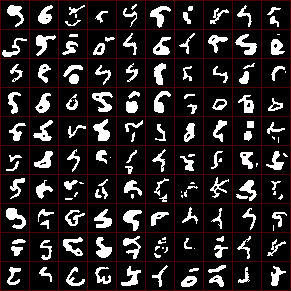

In [321]:
CLASS = 5
p=preds[:, CLASS]
img = X[np.argsort(p)[::-1]]
#img = img[ (p[np.argsort(p)[::-1]])>0.5 ]
img = disp_grid(img[0:100], border=1, bordercolor=(0.3, 0, 0))
imsave('imgs/out.png', img)
Image('imgs/out.png')

In [450]:
real = data[y==5][0:10]
fake = X[np.argsort(p)[::-1]][0:100]
is_real = np.array([1] * len(real) + [0] * len(fake))
points = fake
#points = points.reshape((points.shape[0], -1))

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


((10, 31, 1, 28, 28), (10, 30))


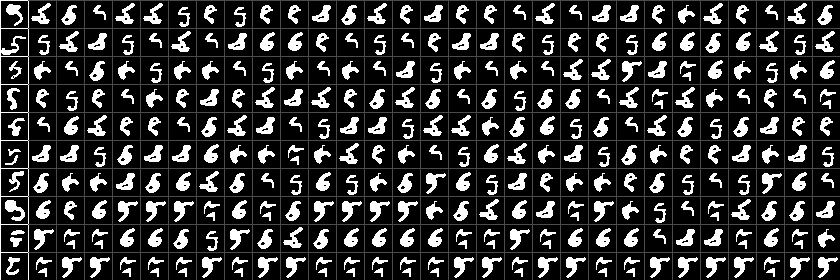

In [497]:
nb_neighb = 30
c=1
h,w=28,28
generated = points[0:10]
dataset = points[10:]
def euc(x, y):
    x = x.reshape((x.shape[0], -1))
    y = y.reshape((y.shape[0], -1))
    x = x[None, :, :]
    y = y[:, None, :]
    axes = np.arange(2, len(x.shape))
    return ((x-y)**2).mean(axis=axes)

dist = euc

neighb = (dist(generated, dataset)).argsort(axis=1)
neighb = neighb[0:nb_neighb, :]
shape = neighb.shape
neighb = neighb.flatten()
neighb = dataset[neighb]
neighb = neighb.reshape((shape[0], shape[1], c, h, w))
neighb = np.concatenate((generated[None,:], neighb), axis=0)
neighb = neighb.transpose((1, 0, 2, 3, 4))
shape = shape[1], shape[0]
print(neighb.shape, shape)
img = np.empty(( shape[0]*h, shape[1] *w, c))
for y in range(shape[0]):
    for x in range(shape[1]):
        img[y*h:y*h+h, x*w:x*w+w] = neighb[y,x].transpose((1, 2, 0))
        img[y*h:y*h+h, x*w:x*w+1]=0.3 if x>1 else 1
        img[y*h:y*h+1, x*w:x*w+w+1]=0.3 if x>0 else 1
imsave('imgs/neigh.png', img[:,:,0] if c==1 else img)
Image('imgs/neigh.png')

In [581]:
def sample():
    rng = np.random
    pt = dict(
        n_components=2,
        perplexity=rng.choice((2, 5, 10, 30, 50, 100)),
        early_exaggeration=rng.randint(1, 10),
        learning_rate=rng.randint(100, 1000), 
        n_iter=5000,
        n_iter_without_progress=500, 
        min_grad_norm=0, 
        metric='euclidean', 
        init=rng.choice(('pca', 'random')),
        verbose=0, 
        random_state=None,
        method='barnes_hut', 
        angle=0.5
    )
    return pt

def run(pt):
    points_ = points.reshape((points.shape[0], -1))
    return TSNE(**pt).fit(points_)

jobs = [sample() for _ in range(100)]
models = Parallel(n_jobs=10, verbose=1)(delayed(run)(j) for j in jobs)
kl = map(lambda m:m.kl_divergence_, models)

[Parallel(n_jobs=10)]: Done   1 out of 100 | elapsed:    2.1s remaining:  3.4min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   13.5s finished


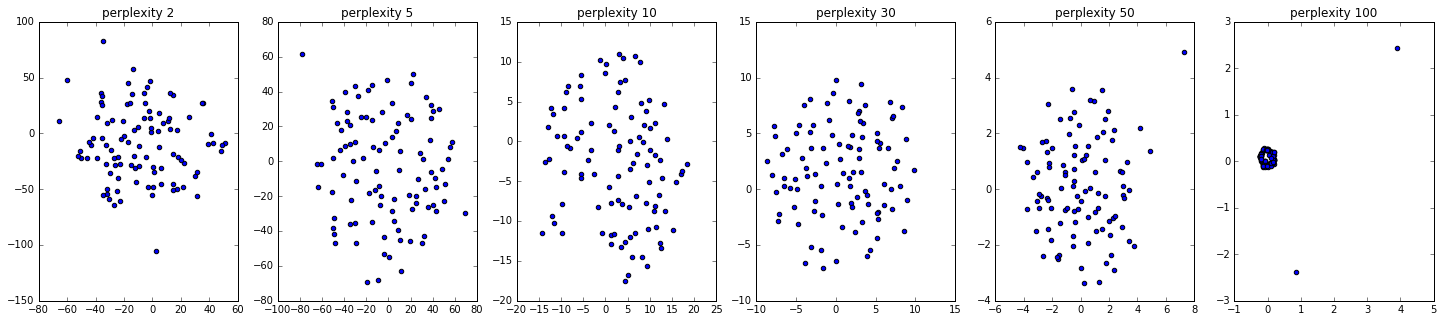

In [582]:
from collections import defaultdict
perplexities = defaultdict(list)
for m in models:
    perplexities[m.perplexity].append(m)
fig, ax = plt.subplots(1, len(perplexities), figsize=(25, 5))
i = 0
for perp in sorted(perplexities.keys()):
    tsne = min(perplexities.get(perp), key=lambda model:model.kl_divergence_)
    embedding = tsne.embedding_
    ax[i].scatter(embedding[:, 0], embedding[:, 1])
    ax[i].set_title('perplexity {}'.format(perp))
    i += 1
plt.show()

In [583]:
tsne = min(perplexities[10], key=lambda m:m.kl_divergence_)
embedding = tsne.embedding_

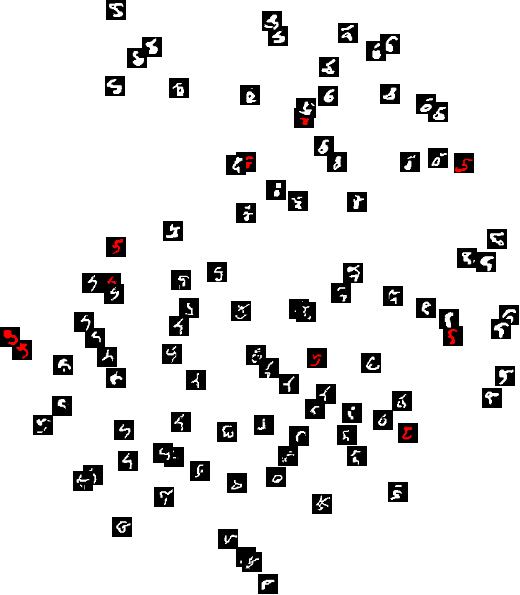

In [587]:
from tools.viz.image_scatter import image_scatter
pts = points.reshape((points.shape[0], 28, 28)).copy()
pts = pts[:, :, :, None] * np.ones((1, 1, 1, 3))
pts[0:10, :, :, 1:]=0
img = image_scatter(embedding, pts, 20, 500)
imsave('imgs/out.png', img)
Image('imgs/out.png')

## checking stats of jobs

In [ ]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset75')
S = [j['summary'] for j in jobs]

In [ ]:
jobs_gen = to_generation(jobs, db=db)

In [ ]:
field = 'stats.out_of_the_box_classification.m2.objectness'
indices = np.arange(len(jobs))
for i in range(len(jobs_gen)):
    j = jobs_gen[i]
    v = db.get_value(j, field, if_not_found=None)
    if not v:print('Misssing generation jobs from training job : {}, skip it.'.format(jobs[i]['summary']))

In [ ]:
import shutil
indices = np.arange(len(jobs))
objectness = map(lambda j:db.get_value(j, field, if_not_found=np.nan), jobs_gen)
objectness = np.array(objectness)
indices = filter(lambda ind:not np.isnan(objectness[ind]), indices)
indices = sorted(indices, key=lambda i:objectness[i])
indices = indices[::-1]
images = ['../exported_data/figs/generated/jobset{:05d}/{}.png'.format(int(jobs[i]['where'][6:]), jobs_gen[i]['summary']) 
          for i in indices]
print(jobs_gen[indices[1]]['summary'])
for i in range(len(images)):
    print(jobs_gen[indices[i]]['summary'])
    shutil.copy(images[i], 'export/{:05d}.png'.format(i))
    #display(Image(images[i]), width=100, height=100)

## objectness score

In [ ]:
"""hf = h5py.File('../exported_data/figs/jobset76.hdf5')
X = hf['X']
nb = hf.attrs['nb']
X = X[0:nb]
X[np.isnan(X)] = 0
X = X[X.sum(axis=(1, 2, 3)) > 0]
"""


data = joblib.load('../jobs/results/1e47d7dea091c42c90b71ec06dee4f4d/images.npz')
X = data[:, -1]


"""
from datakit.mnist import load
data = load(which='train')
X = data['train']['X']
y = data['train']['y']
X = X / 255.
"""

print(X.min(), X.max())
print(X.shape)

In [ ]:
preds = model.predict(X)
preds = (preds - preds.min(axis=0, keepdims=True)) / (preds.max(axis=0, keepdims=True) - preds.min(axis=0, keepdims=True))
objectness = compute_sample_objectness(preds)

In [ ]:
ind = np.argsort(objectness)[::-1]
X_sorted = X[ind]
preds_sorted = preds[ind]
objectness_sorted = objectness[ind]

In [ ]:
sample = np.arange(len(X))
np.random.shuffle(sample)
sample = sample[0:1000]

objectness_sampled = objectness[sample]
X_sampled = X[sample]
preds_sampled = preds[sample]
X_sampled = X_sampled[np.argsort(objectness_sampled)[::-1]]
preds_sampled = preds_sampled[np.argsort(objectness_sampled)[::-1]]

In [ ]:
im = disp_grid_with_pred(X_sorted[0:400], preds_sorted[0:400])
imsave('imgs/out.png', im)
Image('imgs/out.png', width=800, height=800)